In [59]:
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multitest import fdrcorrection

In [92]:
# Analysis parameters

# Filter out non-market samples and amplicon sequenced samples
exclude_sample_types = ['sars2_amplicon','not_market', 'single_end_duplicate']

# Limit analysis to 1/Jan/2020 and 12/Jan/2020 samples
include_dates = [datetime.datetime(2020, 1, 1), datetime.datetime(2020, 1, 12)]

# set minimum number of samples a species must be identified in for analysis
min_samples = 3

# Number of bootstrapped samples (with replacement)
nBoot = 1000

# False-detection rate correction by BH procedure for independent tests with α = 0.05; statsmodels.stats.multitest.fdrcorrection

In [93]:
# Build dataframe with taxonomic information
species_taxa = pd.read_csv('../mtDNA/species_descriptions_with_common_name.csv')
contig_species = species_taxa['Contig'] + ' ' + species_taxa['Species']
common_names_dict = dict(zip(contig_species, species_taxa['Common_name'])) # create dictionary of common names
category_dict = dict(zip(contig_species, species_taxa['Category'])) # category including if observed in Xiao 2021
mammal_dict = dict(zip(contig_species,species_taxa['Class']=='Mammalia'))
class_dict = dict(zip(contig_species,species_taxa['Class']))

In [94]:
# Organize sample data
sample_metadata = pd.read_csv('../metadata/Sequencing_run_info.tsv',sep='\t')
sample_type_dict = dict(zip(sample_metadata['Run'],sample_metadata['Sample_Type']))
sample_reads_dict = dict(zip(sample_metadata['Run'],sample_metadata['Read_pairs_after_trimming']))

sample_info = pd.read_csv('../metadata/Liu_etal_2023_with_sequencing.csv')
sample_info['Sampling date'] = pd.to_datetime(sample_info['Sampling.date'],format='%Y-%m-%d')

# create dictionary of sample dates
sample_date_dict = dict(zip(sample_info['Sequencing_Run'], sample_info['Sampling date']))

In [95]:
# Load and process sars2 reads
reads_sars2 = pd.read_csv('../SARS2/sars2_reads_post_trimming.tsv',sep='\t')
sars2_dict = dict(zip(reads_sars2['Sample'],reads_sars2['Read_count']))

# Load species reads and filter both species and sars2 reads by sample type and sample date
reads_species = pd.read_csv('../mtDNA/mitochondrial_metazoa_counts_93.tsv',sep='\t').drop(['Lab code','Sample_category','Sample_Name','Stall_corrected'],axis=1)

reads_species['Sample_type'] = reads_species.apply(lambda x:sample_type_dict[x.Run],axis=1)
reads_species = reads_species.query('Sample_type!=@exclude_sample_types')

reads_species['Sampling_date'] = reads_species.Run.map(sample_date_dict)
reads_species = reads_species.query('Sampling_date==@include_dates')

runs = reads_species['Run'].unique().tolist()
reads_sars2 = reads_sars2.query('Sample==@runs')

reads_species['reads_sars2'] = reads_species.apply(lambda x:sars2_dict[x.Run],axis=1)
reads_species['reads_total'] = reads_species.apply(lambda x:sample_reads_dict[x.Run],axis=1)

# melt data frame and get common names and whether or not a mammal
reads_cols = reads_species.columns.to_list()
reads_species = reads_species.melt(id_vars=reads_cols[0:1] + reads_cols[-4:],var_name='Contig_species',value_name='reads_species')

# For each sample/species row get common name, whether or not a mammal, and assign total number of mapped reads
reads_species['Common_name'] = reads_species.apply(lambda x: common_names_dict[x.Contig_species],axis=1)
reads_species['Category'] = reads_species.apply(lambda x: category_dict[x.Contig_species],axis=1)
reads_species['Mammal'] = reads_species.apply(lambda x: mammal_dict[x.Contig_species],axis=1)
reads_species['Class'] = reads_species.apply(lambda x: class_dict[x.Contig_species],axis=1)
reads_species['Species'] = reads_species.apply(lambda x: ' '.join(x.Contig_species.split(' ')[1:]),axis=1)

reads_species.mapped_total = 0

for run in runs:
    m = reads_species.query('Run==@run').reads_species.sum()
    reads_species.loc[reads_species['Run']==run,'mapped_total'] = m

# Calculate fraction of species and sars2 reads normalizing by both total reads and mammal reads (may be less prone to correlated multiplicative error)
reads_species['fraction_sars2_total'] = reads_species['reads_sars2'] / reads_species['reads_total']
reads_species['fraction_species_total'] = reads_species['reads_species'] / reads_species['reads_total']
reads_species['fraction_species_mapped'] = reads_species['reads_species'] / reads_species['mapped_total']

In [96]:
# Calculate Spearman correlation and p value (significantly above or below zero; no correction for multiple hypotheses) for all species and sampling dates

dates = [[datetime.datetime(2020, 1, 1)],[datetime.datetime(2020, 1, 12)],[datetime.datetime(2020, 1, 1),datetime.datetime(2020, 1, 12)]]
all_species = reads_species['Species'].unique()

species_stats = pd.DataFrame(columns=['Species', 'Common name', 'Class', 'Date','Total_correlation','Total_pvalue','Mapped_correlation','Mapped_pvalue','Number_samples','Number_reads'])
dates_raw = []
for species in all_species:
    
    for date in dates:
        
        d = reads_species.query('`Sampling_date`==@date & Species==@species')
        
        common_name = d.iloc[0].Common_name
        species_class = d.iloc[0].Class
        category = d.iloc[0].Category
        number_samples = (d.reads_species>0).sum()
        number_reads = d.reads_species.sum()
        
        if d.fraction_species_mapped.sum()>0:

            res_spearman_mapped = stats.spearmanr(d.fraction_species_mapped, d.fraction_sars2_total) # normalize to animal reads
            res_spearman_total = stats.spearmanr(d.fraction_species_total, d.fraction_sars2_total) # normalize to total reads
            res_spearman_raw = stats.spearmanr(d.reads_species, d.reads_sars2) # normalize to total reads
            
            species_stats.loc[len(species_stats), ['Species','Common name', 'Class', 'Category', 'Date','Total_correlation','Total_pvalue','Mapped_correlation','Mapped_pvalue','Raw_correlation','Raw_pvalue','Number_samples','Number_reads']] = species, common_name, species_class, category, ','.join([d.strftime('%d-%b-%Y') for d in date]), res_spearman_total.statistic, res_spearman_total.pvalue,res_spearman_mapped.statistic, res_spearman_mapped.pvalue, res_spearman_raw.statistic, res_spearman_raw.pvalue, number_samples, number_reads
            dates_raw.append(date)

species_stats['dates_raw'] = dates_raw
d = species_stats.query('Number_samples>=@min_samples')

In [145]:
# Calculate adjusted P values and write summary tables

d2 = d.copy()
d2.Date = d2.Date.astype(str)
d2 = d2.query("Date == '12-Jan-2020' & Class == 'Mammalia'")
d2['Total_padj'] = fdrcorrection(d2['Total_pvalue'])[1]
d2['Mapped_padj'] = fdrcorrection(d2['Mapped_pvalue'])[1]
d2['Raw_padj'] = fdrcorrection(d2['Raw_pvalue'])[1]

d2.sort_values("Total_padj").to_csv("correlation_results.tsv", sep="\t", index=None)
d.query("Date == '12-Jan-2020'").query("Class != 'Mammalia'").to_csv("correlation_results_nomammal.tsv", sep="\t", index=None)

pd.options.display.float_format = '{:.4f}'.format
print('Table SX. Spearman ranked correlation between SARS-CoV-2 and species-mapped reads in 12-Jan-2020 samples (n=70) for species detected in 3 or more samples. Correlation, p-values, and adjusted p-values.\n')
print(d2.sort_values("Total_padj")[['Common name','Number_samples','Total_correlation','Total_pvalue','Total_padj']].to_string(index=False))

d2 = d2.sort_values('boot_mean',ascending=False)
print('\nTable SX. Spearman ranked correlation between SARS-CoV-2 and species-mapped reads in 12-Jan-2020 samples (n=70) for species detected in 3 or more samples. Bootstrapped (n=1000) estimate of p-values and 95% CI.\n')
print(pd.concat([d2, d2[['boot_mean','boot_min','boot_max']].apply(['mean'])])[['Common name','boot_mean','boot_min','boot_max']].to_string(index=False))

Table SX. Spearman ranked correlation between SARS-CoV-2 and species-mapped reads in 12-Jan-2020 samples (n=70) for species detected in 3 or more samples. Correlation, p-values, and adjusted p-values.

       Common name Number_samples Total_correlation Total_pvalue Total_padj
 Malayan porcupine             10            0.4584       0.0001     0.0013
  Himalayan marmot              4            0.3445       0.0035     0.0332
     Amur hedgehog             27            0.3068       0.0098     0.0620
               dog             45            0.2426       0.0430     0.2044
             human             52            0.1397       0.2486     0.5212
           red fox             10           -0.1243       0.3051     0.5212
            nutria              7           -0.1017       0.4020     0.5212
   Reeves' muntjac             20            0.1544       0.2018     0.5212
        Arctic fox              8           -0.1096       0.3665     0.5212
      domestic cat             11     

<Axes: xlabel='Total_correlation', ylabel='Mapped_correlation'>

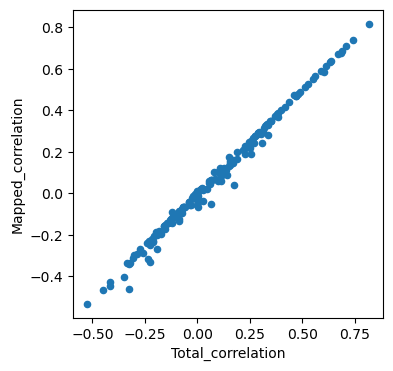

In [98]:
# Compare correlations with species reads normalized to total number of sample reads or number of species-mapped reads

plt.rcParams["figure.figsize"] = (4,4)
d.plot.scatter("Total_correlation","Mapped_correlation")

# Total Reads normalized Data

In [99]:
# Calculate Spearman correlation and 95% confidence intervals for 1/Jan samples with non-zero species-mapped reads

def bootstrap_spearmanr(df):
    while True:
        bootstrapped = df.sample(n=len(df), replace=True)
        if bootstrapped.fraction_species_total.std() != 0 and bootstrapped.fraction_sars2_total.std() != 0:
            return stats.spearmanr(bootstrapped.fraction_species_total, bootstrapped.fraction_sars2_total).statistic

def run_bootstrap(df):
    bs = [bootstrap_spearmanr(df)
      for i in range(nBoot)]
    return  np.mean(bs),np.percentile(bs,2.5),np.percentile(bs,97.5)

boot_min = []
boot_max = []
boot_mean = []

for index, row in d.iterrows():
    date = row['dates_raw'] 
    species = row['Species']
    data = reads_species.query('`Sampling_date`==@date & Species==@species')
    b_mean,b_min,b_max=run_bootstrap(data)
    boot_mean.append(b_mean)
    boot_max.append(b_max)
    boot_min.append(b_min)
    
d = d.assign(boot_min=boot_min, boot_mean= boot_mean, boot_max= boot_max)

<Axes: xlabel='Total_correlation', ylabel='boot_mean'>

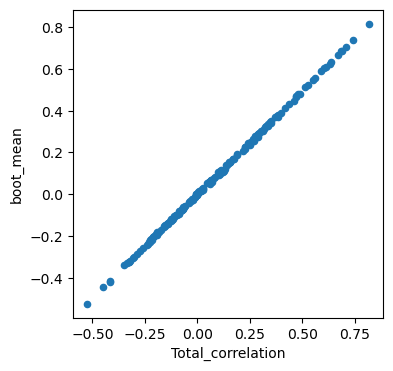

In [100]:
# Compare single estimate to mean of bootstrapped estimates

plt.rcParams["figure.figsize"] = (4,4)

lower_ci = d.boot_mean.values - d.boot_min.values
upper_ci = d.boot_max.values - d.boot_min.values

d.plot.scatter("Total_correlation", "boot_mean")
# d.plot.scatter("Total_correlation", "boot_mean",yerr=np.array([upper_ci,lower_ci])) # plot with 95% CI if desired

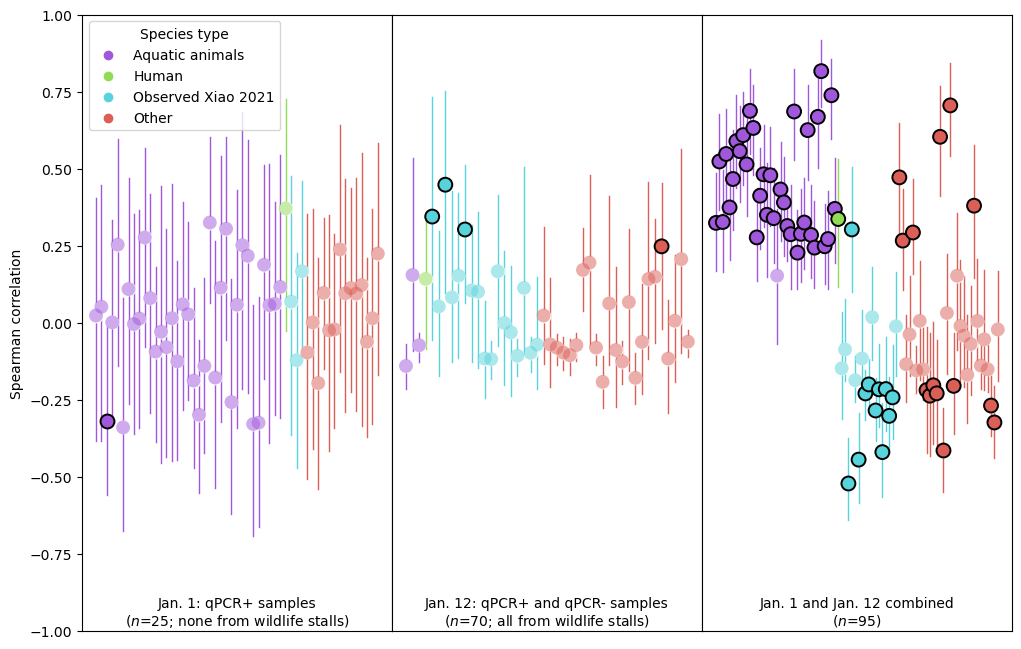

In [111]:
# Compare Spearman correlations of relative abundances on 01-Jan and 12-Jan-2020 highlighting species with uncorrected p < 0.05

plot_dates = ['01-Jan-2020',
              '12-Jan-2020',
              '01-Jan-2020,12-Jan-2020']

plot_labels = ['Jan. 1: qPCR+ samples\n($\it{n}$=25; none from wildlife stalls)',
               'Jan. 12: qPCR+ and qPCR- samples\n($\it{n}$=70; all from wildlife stalls)',
               'Jan. 1 and Jan. 12 combined\n($\it{n}$=95)']

plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams['svg.fonttype'] = 'none'

palette = sns.color_palette('hls',n_colors=4)

cat2color = {}
j = 0
for cat in d.Category.unique():
    cat2color[cat] = palette[j]
    j += 1

for i in range(len(plot_dates)):

    plt.subplot(1,3,i+1)

    plot_data = d[d.Date.astype(str) == plot_dates[i]].sort_values(['Category'])
    
    for index, row in plot_data.iterrows():
        new_df = {}
        new_df['values'] = [row['boot_min'], row['boot_max']]
        new_df['x'] = [row['Species'], row['Species']]
        new_df = pd.DataFrame(new_df)
        sns.lineplot(data=new_df, x='x', y='values', color=cat2color[row['Category']], alpha=1, estimator=None, linewidth=1, zorder=-1)

    # Aesthetic changes leaving g0 and g1 here or g1 below commented out
    g0 = sns.scatterplot(plot_data, x='Species', y='boot_mean', s=100, linewidth=0, alpha=1, color='white')
    g1 = sns.scatterplot(plot_data, x='Species', y='boot_mean', hue='Category', s=100, linewidth=0, alpha=0.5, edgecolor='white', palette = cat2color)
    
    # g1 = sns.scatterplot(plot_data, x='Species', y='boot_mean', hue='Category', s=50, linewidth=0.5, alpha=1, edgecolor='white', palette = cat2color)
    
    g2 = sns.scatterplot(plot_data.query('Total_pvalue < 0.05'), x='Species', y='boot_mean', hue='Category', s=100, linewidth=1.4, edgecolor='black', palette = cat2color)
    
    plt.ylim(-1,1)
    plt.xticks([])

    if i == 0:
        h,l = g1.get_legend_handles_labels()
        plt.legend(h[0:4],l[0:4],loc='upper left',title='Species type')
        plt.ylabel('Spearman correlation')
    else:
        ax = plt.gca()
        ax.legend_ = None
        plt.ylabel(None)
        plt.yticks([])
    
    plt.xlabel(plot_labels[i],loc='center',labelpad=-25)

# plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

plt.savefig('correlation.svg',bbox_inches='tight')
plt.savefig('correlation.png',bbox_inches='tight')